# **AdEase Casestudy - Time Series**

### **About AdEase**
Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks at minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

### **Problem Statement**
You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.


#### **Data Dictionary:**

There are two csv files given
1. **train_1.csv:** In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

2. **Exog_Campaign_eng:** This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There is 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

#### **Concepts Used:**

**1. Exploratory data analysis**

**2. Time Series forecasting- ARIMA, SARIMAX, and Prophet**

**Questionnaire:**

* Defining the problem statements and where can this and modifications of this be used?

* Write 3 inferences you made from the data visualizations

* What does the decomposition of series do?

* What level of differencing gave you a stationary series?

* Difference between arima, sarima & sarimax.

* Compare the number of views in different languages

* What other methods other than grid search would be suitable to get the model for all languages?

In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (18, 9)

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("Adease_train.csv")
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
df.shape

(145063, 551)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## **Exploratory Data Analysis**

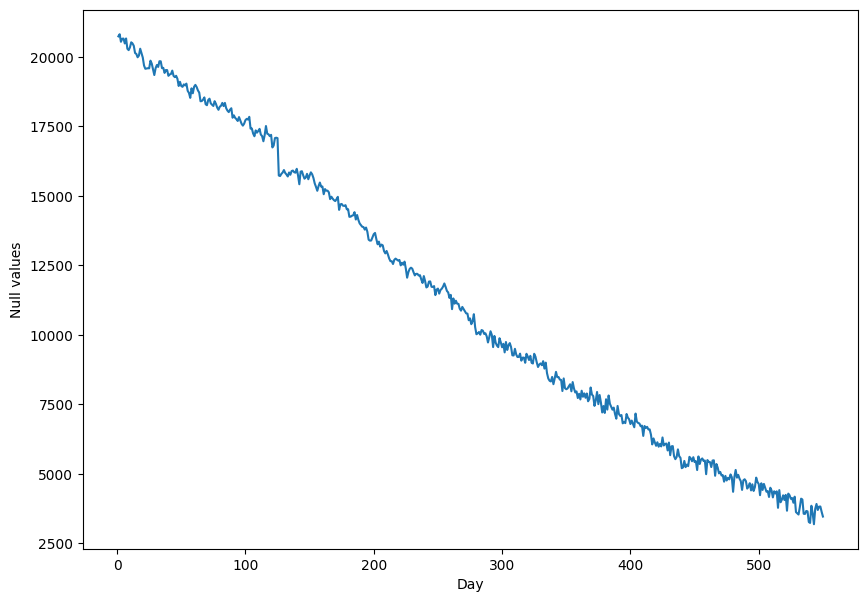

In [6]:
days = [r for r in range(1, len(df.columns))]
plt.figure(figsize=(10,7))
plt.xlabel('Day')
plt.ylabel('Null values')
plt.plot(days, df.isnull().sum()[1:])

* We see that the number of null values decrease with time.
* Some website have all nan values in the beginning, that can be due to the fact that those were created after that time so there is no traffic reading for that time 

In [7]:
df.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [8]:
# We fill all the nan values with zero assuming there was no traffic on the date ie, there is zero views.
# So it is not considered as null values.
df.fillna(value=0, inplace=True)

Separating different values from Page feature like title, language, access type, and access origin.

> SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
* Specific Name corresponds to page name, the main domain,
* Access type refers to the device type used to access the page, and 
* Access origin refers to the request origin ( spider or browser )

In [9]:
df['Page'].replace("www.mediawiki.org","wikipedia.org")
df['Page'].replace("wikimedia.org","wikipedia.org")

0                   2NE1_zh.wikipedia.org_all-access_spider
1                    2PM_zh.wikipedia.org_all-access_spider
2                     3C_zh.wikipedia.org_all-access_spider
3                4minute_zh.wikipedia.org_all-access_spider
4         52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
                                ...                        
145058    Underworld_(serie_de_películas)_es.wikipedia.o...
145059    Resident_Evil:_Capítulo_Final_es.wikipedia.org...
145060    Enamorándome_de_Ramón_es.wikipedia.org_all-acc...
145061    Hasta_el_último_hombre_es.wikipedia.org_all-ac...
145062    Francisco_el_matemático_(serie_de_televisión_d...
Name: Page, Length: 145063, dtype: object

In [10]:
def split_page(page):
  w = re.split('_|\.', page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(df.Page.apply(split_page))
df_new = pd.DataFrame(li)
df_new.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([df_new, df], axis = 1)
df.head()

,Title,Language,Access_type,Access_origin,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52 Hz I Love You,zh,all-access,spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [11]:
# data['Language'] = data['Language'].replace(['commons','www'],'no_lang')
def lang(Page):
  val = re.search('[a-z][a-z].wikipedia.org',Page)
  if val:
    return val[0][0:2]

  return 'no_lang'

df['Language']=df['Page'].apply(lambda x: lang(str(x)))

{'ja':'Japaneese', 'de':'German',  'en' : 'English',  'no_lang':'Media_File',  'fr':'French',  'zh':'Chinese',  'ru':'Russian',  'es':'Spanish'}


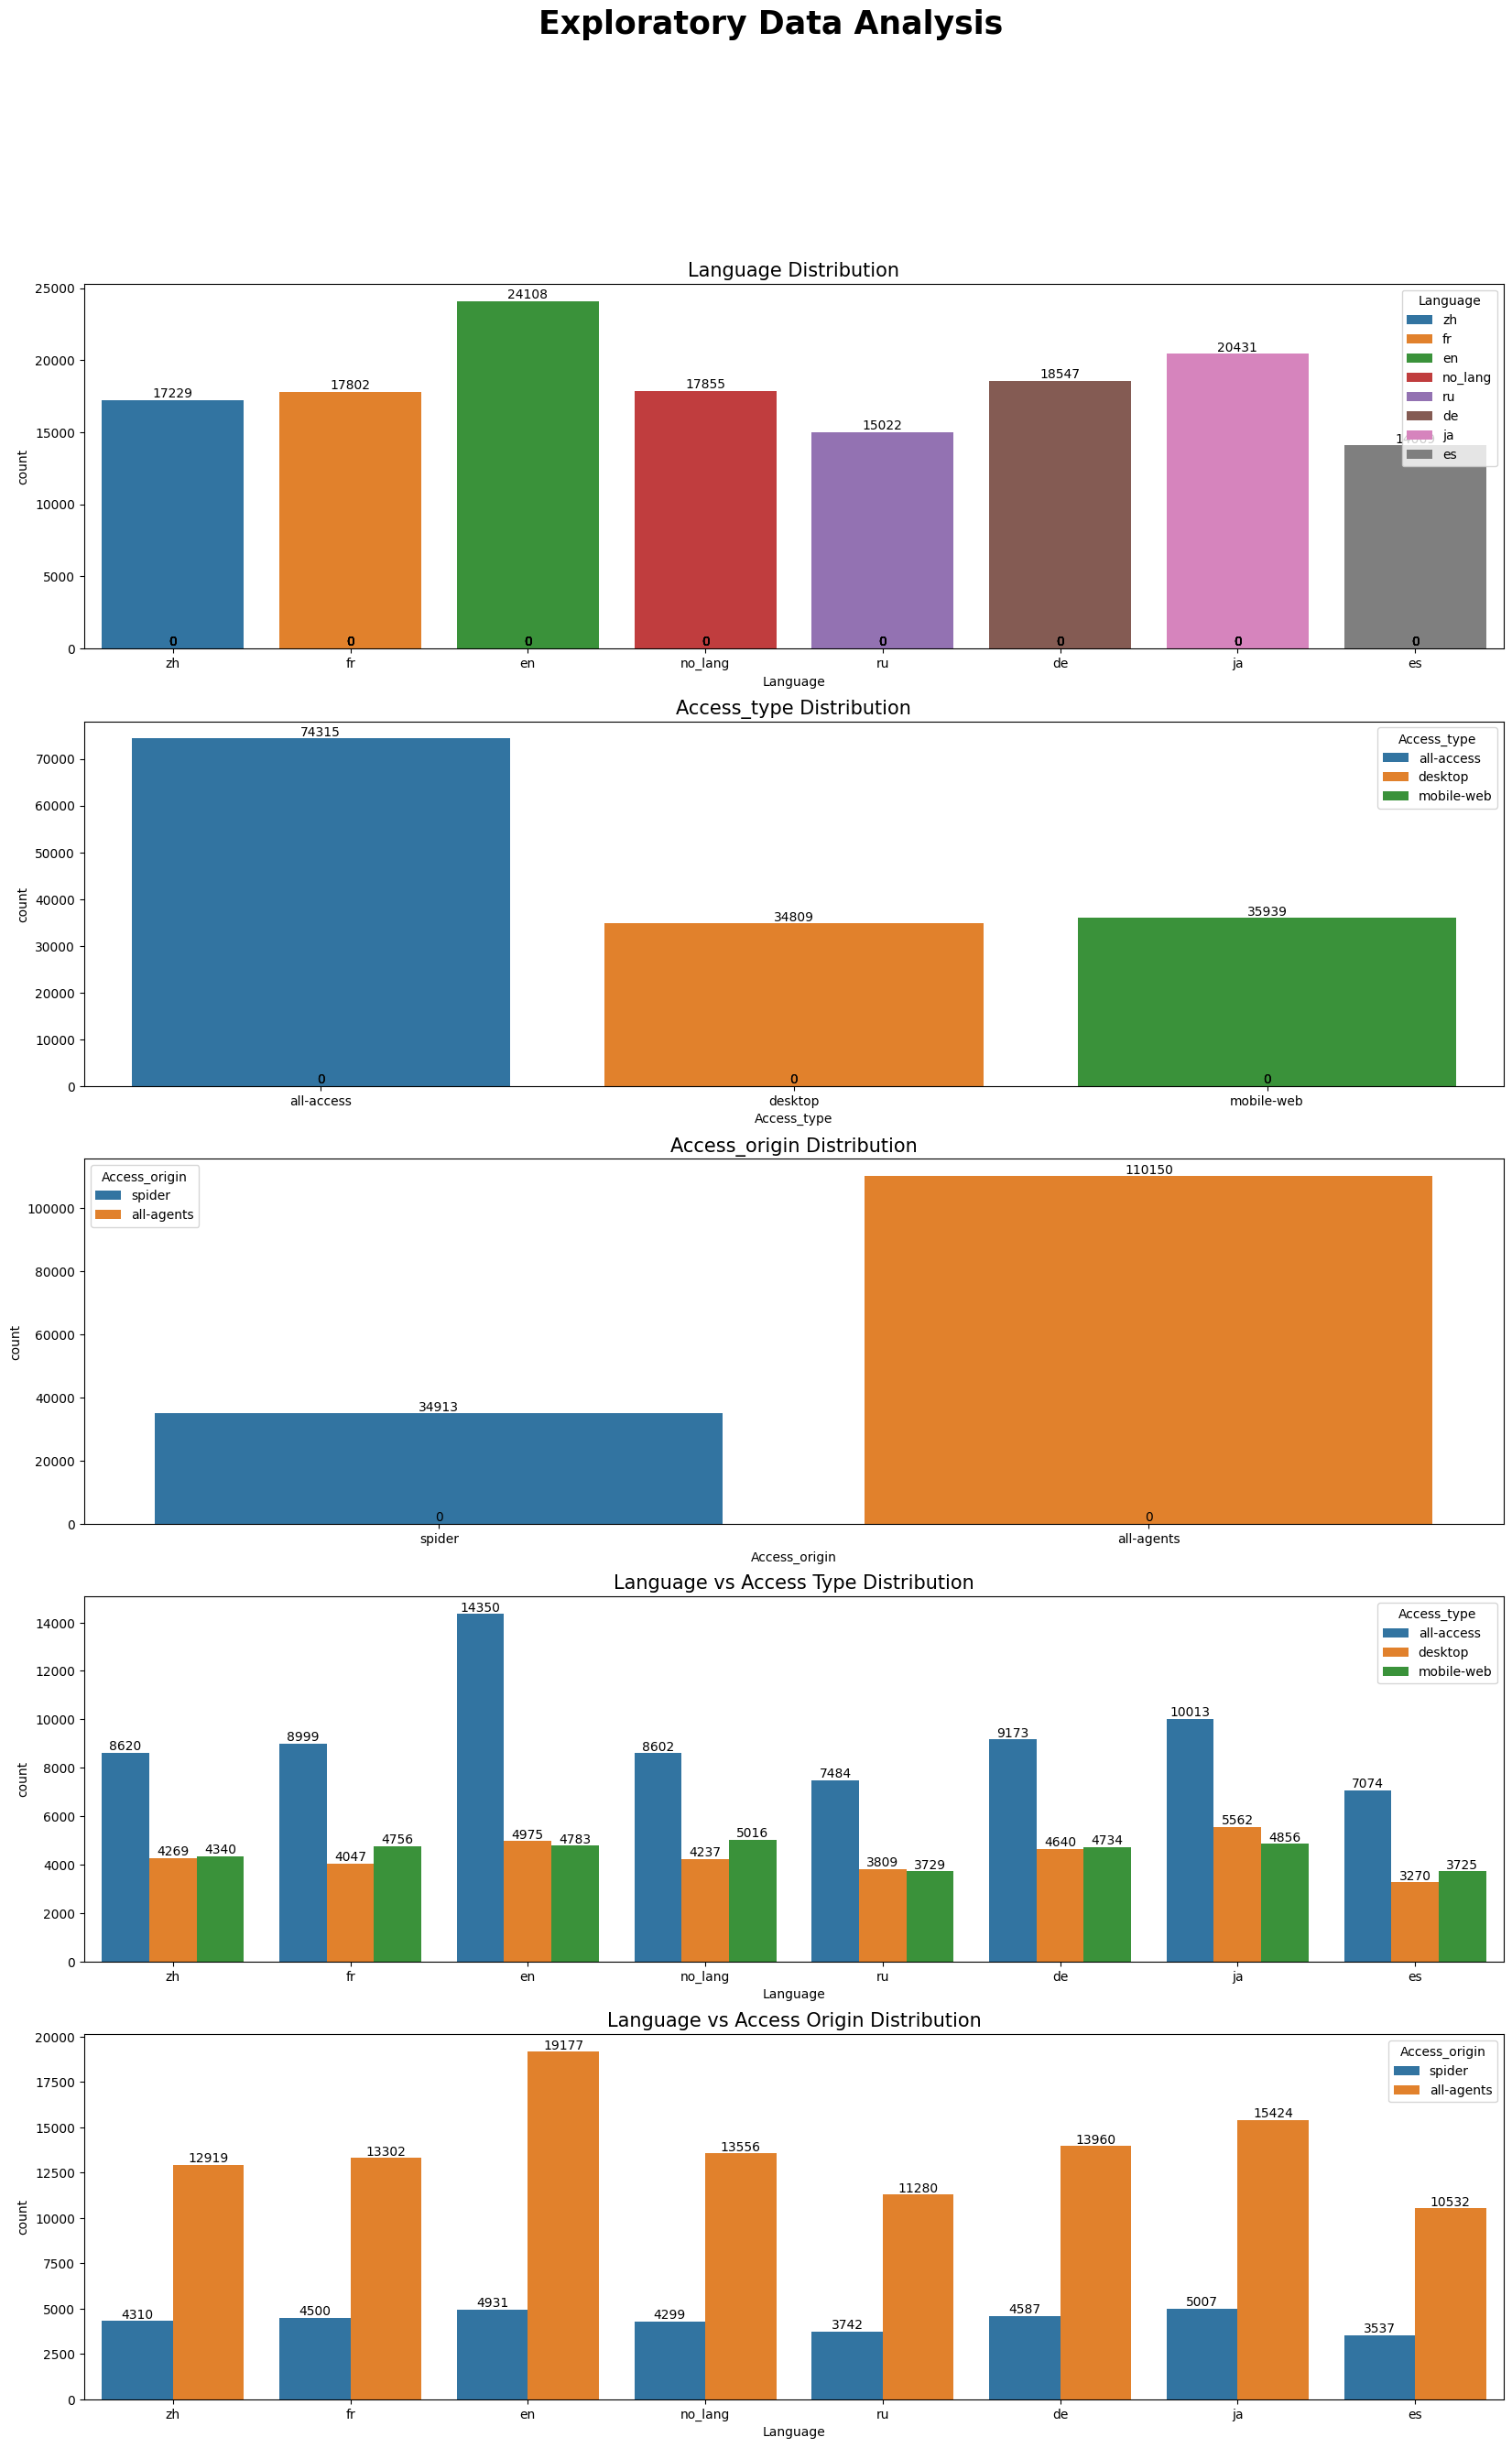

In [12]:
fig, axs = plt.subplots(5,1, figsize=(20,30), sharey=False)
fig.suptitle("Exploratory Data Analysis" , fontsize=25, fontweight='bold')
graph = sns.countplot(x = 'Language', hue= 'Language', data= df, dodge = False,ax=axs[0])
for i in graph.containers:
  graph.bar_label(i,)
graph.set_title("Language Distribution", fontsize = 15)

graph2 = sns.countplot(x = 'Access_type', hue = 'Access_type', data = df , dodge=False,ax=axs[1])
for i in graph2.containers:
  graph2.bar_label(i,)
graph2.set_title("Access_type Distribution", fontsize = 15)

graph3 = sns.countplot(x = 'Access_origin', hue = 'Access_origin' ,data = df , dodge=False,ax=axs[2])
for i in graph3.containers:
 graph3.bar_label(i,)
graph3.set_title("Access_origin Distribution", fontsize = 15)

graph4 = sns.countplot(x = 'Language', hue = 'Access_type' ,data = df , ax=axs[3])
for i in graph4.containers:
 graph4.bar_label(i,)
graph4.set_title("Language vs Access Type Distribution", fontsize = 15)

graph5 = sns.countplot(x = 'Language', hue = 'Access_origin' ,data = df , ax=axs[4])
for i in graph5.containers:
 graph5.bar_label(i,)
graph5.set_title("Language vs Access Origin Distribution", fontsize = 15)
plt.show()

* English is the most spoken language
* The usage from desktop and mobile is almost the same for access_type category.
* This shows that organic view is far more than that of spiders or bots in access_origin category.

### Language

In [13]:
df.groupby('Language').count()  

,Title,Access_type,Access_origin,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Language,,,,,,,,,,,,,,,,,,,,,
de,18547,18547,18547,18547,18547,18547,18547,18547,18547,18547,...,18547,18547,18547,18547,18547,18547,18547,18547,18547,18547
en,24108,24108,24108,24108,24108,24108,24108,24108,24108,24108,...,24108,24108,24108,24108,24108,24108,24108,24108,24108,24108
es,14069,14069,14069,14069,14069,14069,14069,14069,14069,14069,...,14069,14069,14069,14069,14069,14069,14069,14069,14069,14069
fr,17802,17802,17802,17802,17802,17802,17802,17802,17802,17802,...,17802,17802,17802,17802,17802,17802,17802,17802,17802,17802
ja,20431,20431,20431,20431,20431,20431,20431,20431,20431,20431,...,20431,20431,20431,20431,20431,20431,20431,20431,20431,20431
no_lang,17855,17855,17855,17855,17855,17855,17855,17855,17855,17855,...,17855,17855,17855,17855,17855,17855,17855,17855,17855,17855
ru,15022,15022,15022,15022,15022,15022,15022,15022,15022,15022,...,15022,15022,15022,15022,15022,15022,15022,15022,15022,15022
zh,17229,17229,17229,17229,17229,17229,17229,17229,17229,17229,...,17229,17229,17229,17229,17229,17229,17229,17229,17229,17229


In [14]:
df_language=df.groupby('Language').mean().transpose()
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)
df_language.head()

Language,de,en,es,fr,ja,no_lang,ru,zh
index,,,,,,,,
2015-07-01,714.968405,3513.862203,1085.972919,475.150994,580.647056,83.479922,629.999601,240.582042
2015-07-02,705.229741,3502.511407,1037.814557,478.202000,666.672801,87.471857,640.902876,240.941958
2015-07-03,676.877231,3325.357889,954.412680,459.837659,602.289805,82.680538,594.026295,239.344071
2015-07-04,621.145145,3462.054256,896.050750,491.508932,756.509177,70.572557,558.728132,241.653491
2015-07-05,722.076185,3575.520035,974.508210,482.557746,725.720914,78.214562,595.029157,257.779674


Text(0.5, 0, 'Date')

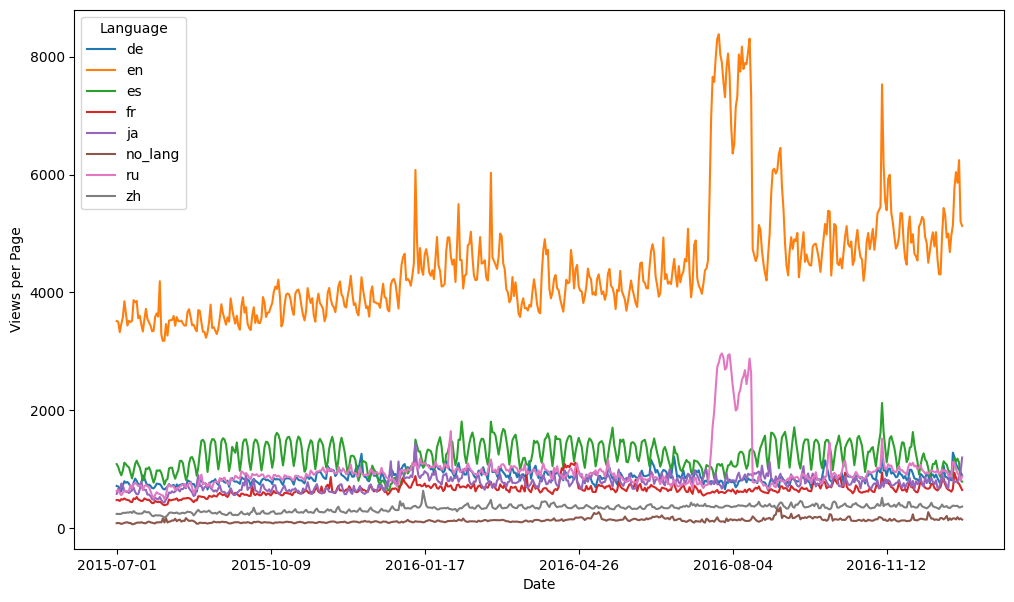

In [15]:
df_language.plot(figsize=(12,7))
plt.ylabel('Views per Page')
plt.xlabel('Date')

* The articles in english got the most number of views as compared to different languages, there are some spikes at different times in different laguages.

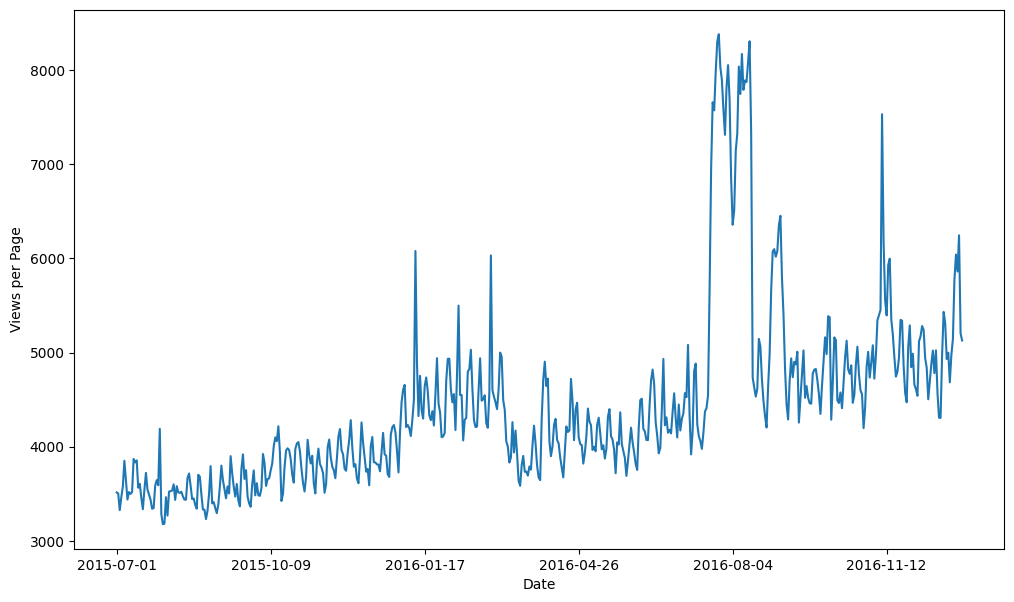

In [16]:
df_language['en'].plot(figsize=(12,7))
plt.ylabel('Views per Page')
plt.xlabel('Date')
plt.show()

In [17]:
df1 = df.copy()
df1.drop('Title',inplace=True,axis=1)

In [18]:
df1['Title'] = df1['Page'].apply(lambda x: x.split('.')[0].split('_')[:x.find('.')])

def concat_strings(strings):
  if len(strings) > 2:
    concatenated = ' '.join(strings[:-1])
    final = concatenated + ' ' + strings[-1]
    return final

# apply function to concatenate all but last element of 'movie_title' column
df1['Title'] = df1['Title'].apply(concat_strings)

df1.head()

,Language,Access_type,Access_origin,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title
0,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,None
1,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,None
2,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,None
3,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,None
4,zh,all-access,spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,52 Hz I Love You zh


In [19]:
df1['Title'].value_counts()

Dancing with the Stars (U                               12
The Voice (U                                            12
Robert Downey Jr                                        11
Donald Trump Jr                                         11
Agents of S                                             11
                                                        ..
Sistema trifásico es                                     1
Carlos Blanco Pérez es                                   1
Análisis DAFO es                                         1
Anexo:Salario mínimo en Venezuela es                     1
Eine Reihe betrüblicher Ereignisse (Fernsehserie) de     1
Name: Title, Length: 32450, dtype: int64

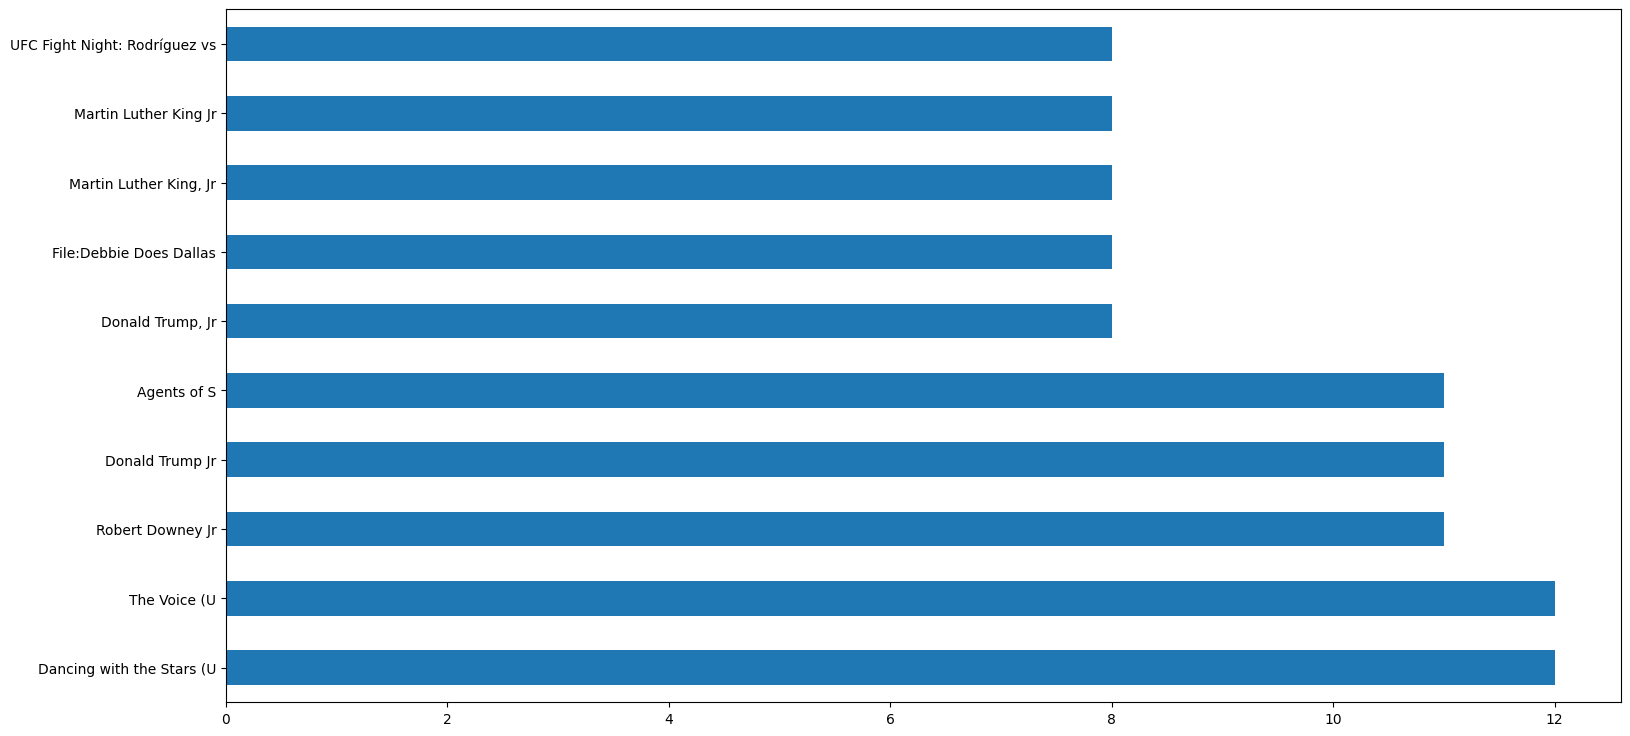

In [20]:
df1['Title'].value_counts().nlargest(10).plot(kind='barh')
plt.show()

Dancing with the Stars is the most popular page viewed.

In [21]:
df_lang = df_language.copy()

## **Checking Stationarity**

### **Augmented Dickey Fuller test (ADH Test)**

**H0 (Null Hypotesis)** : Time Series is non Stationary.

**Ha (Alternate Hypothesis)** : Time Series is Stationary.


In [22]:
# Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
def dickeyfuller_test(x):
    
    print("Dickey Fuller test for : en ")
    dftest = sm.tsa.stattools.adfuller(df_lang['en'])
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
    significance_level = 0.05
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]= value    
    print(dfoutput)
    print("--"*40)
    pvalue = sm.tsa.stattools.adfuller(df_lang['en'])[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')
    
    
dickeyfuller_test(df_lang['en'])

Dickey Fuller test for : en 
Test Statistic                  -2.247284
p-value                          0.189534
Number of lags used             14.000000
Number of observations used    535.000000
Critical value (1%)             -3.442632
Critical value (5%)             -2.866957
Critical value (10%)            -2.569655
dtype: float64
--------------------------------------------------------------------------------
Sequence is not stationary


Here p_value is more than alpha value, so we fail to reject null hypothesis ie, **Time Series is non Stationary.**

### **Different methods for stationarity**

**1. Removing trend and seasonality with decomposition**

In [23]:
en_df = df_lang[['en']]
en_df.index = pd.to_datetime(en_df.index)
en_df.head()

Language,en
index,
2015-07-01,3513.862203
2015-07-02,3502.511407
2015-07-03,3325.357889
2015-07-04,3462.054256
2015-07-05,3575.520035


In [24]:
# Decomposition of series
add_result = sm.tsa.seasonal_decompose (df_lang['en'], model='additive',period = 7)
new_df_add = pd.concat([ add_result.observed, add_result.trend,add_result.seasonal, add_result.resid], axis=1)
new_df_add.columns = [ 'Original data','Trend', 'Seasoanilty','Residual']
print('Decomposition of TS for language : en')
new_df_add.tail()

Decomposition of TS for language : en


,Original data,Trend,Seasoanilty,Residual
index,,,,
2016-12-27,6040.680728,5604.355087,75.512297,360.813345
2016-12-28,5860.227559,5626.652895,1.203413,232.371251
2016-12-29,6245.127510,NaN,-115.839183,NaN
2016-12-30,5201.783018,NaN,-246.075727,NaN
2016-12-31,5127.916418,NaN,-156.906706,NaN


Decompositionof TS for English (en) language 


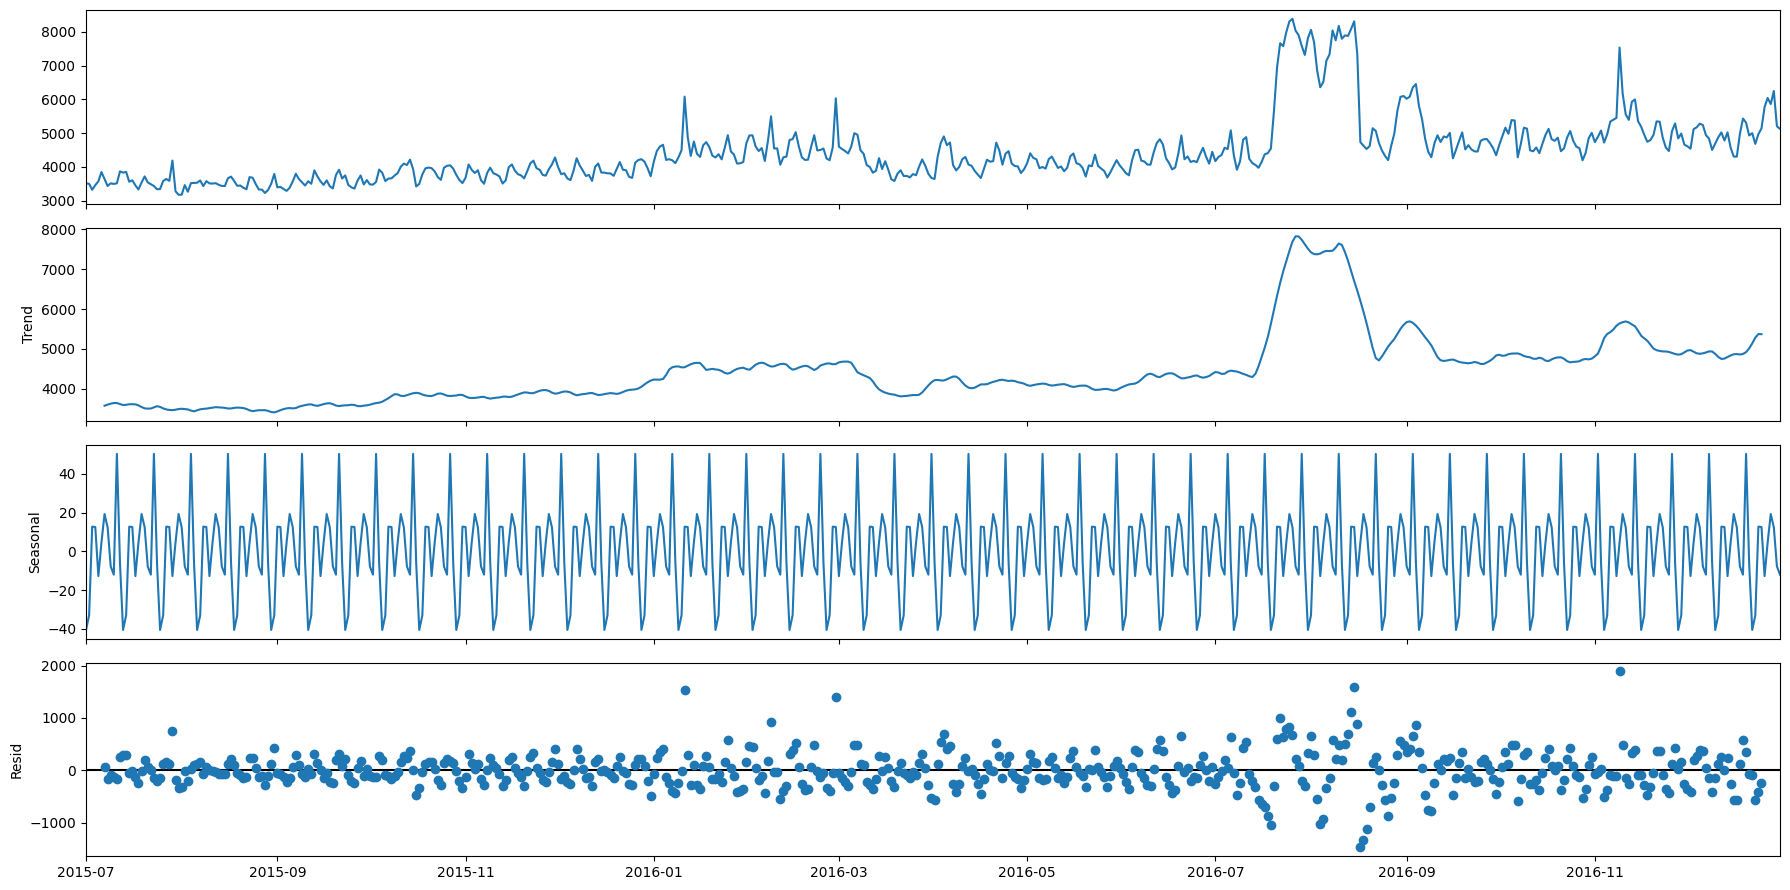

In [25]:
import statsmodels.api as sm
print('Decompositionof TS for English (en) language ')
decompose_result= sm.tsa.seasonal_decompose(en_df, period=12)  # Knowing the right period is V.Imp and You can use ACF to guess the period
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid
decompose_result.plot();

**There is a seaonality for English language and trend is increasing from 2016,Jan.**

In [26]:
from statsmodels.tsa.stattools import adfuller
def dickey_fuller_test(x):  
  print("Dickey Fuller test for : en ")
  dftest = sm.tsa.stattools.adfuller(decompose_result.resid.dropna())
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Number of lags used','Number of observations used'])
  significance_level = 0.05
  for key,value in dftest[4].items():
      dfoutput['Critical value (%s)'%key]= value  
  print(dfoutput)
  print("--"*40)
  pvalue = sm.tsa.stattools.adfuller(decompose_result.resid.dropna())[1] 
  if pvalue <= significance_level:
      print('Sequence is stationary')
  else:
      print('Sequence is not stationary')

dickey_fuller_test(decompose_result.resid.dropna())

Dickey Fuller test for : en 
Test Statistic                -7.687631e+00
p-value                        1.447374e-11
Number of lags used            1.900000e+01
Number of observations used    5.180000e+02
Critical value (1%)           -3.443037e+00
Critical value (5%)           -2.867136e+00
Critical value (10%)          -2.569750e+00
dtype: float64
--------------------------------------------------------------------------------
Sequence is stationary


Here p_value is less than alpha value, so we reject the null hypothesis ie, **Time Series is Stationary.**

**2. Stationarity check using differencing the series**

In [27]:
## detrending

dickey_fuller_test(df_lang['en'].diff().dropna())

Dickey Fuller test for : en 
Test Statistic                -7.687631e+00
p-value                        1.447374e-11
Number of lags used            1.900000e+01
Number of observations used    5.180000e+02
Critical value (1%)           -3.443037e+00
Critical value (5%)           -2.867136e+00
Critical value (10%)          -2.569750e+00
dtype: float64
--------------------------------------------------------------------------------
Sequence is stationary


In [28]:
## deseasonalisation

dickey_fuller_test(df_lang['en'].diff(12).dropna())

Dickey Fuller test for : en 
Test Statistic                -7.687631e+00
p-value                        1.447374e-11
Number of lags used            1.900000e+01
Number of observations used    5.180000e+02
Critical value (1%)           -3.443037e+00
Critical value (5%)           -2.867136e+00
Critical value (10%)          -2.569750e+00
dtype: float64
--------------------------------------------------------------------------------
Sequence is stationary


In [29]:
## deseasonalisation and detrending

dickey_fuller_test(df_lang['en'].diff(12).diff().dropna())

Dickey Fuller test for : en 
Test Statistic                -7.687631e+00
p-value                        1.447374e-11
Number of lags used            1.900000e+01
Number of observations used    5.180000e+02
Critical value (1%)           -3.443037e+00
Critical value (5%)           -2.867136e+00
Critical value (10%)          -2.569750e+00
dtype: float64
--------------------------------------------------------------------------------
Sequence is stationary


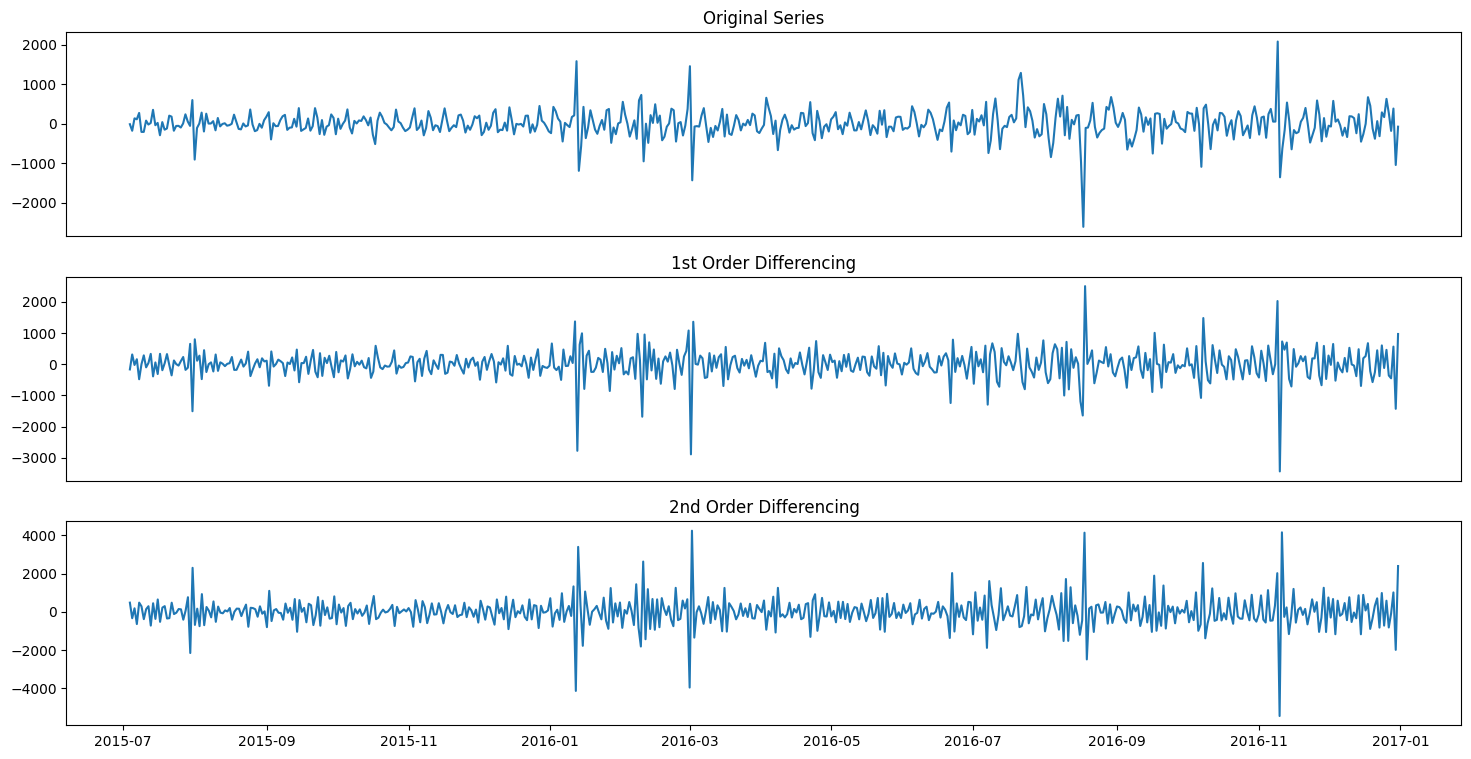

In [30]:
ts_diff =en_df - en_df.shift(1)
ts_diff.dropna(inplace=True)

# Finding the value of the d parameter

fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(ts_diff);
ax1.set_title('Original Series');
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(ts_diff.diff());
ax2.set_title('1st Order Differencing');
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(ts_diff.diff().diff());
ax3.set_title('2nd Order Differencing')
plt.show()


Here we can see the time series has become stationary. One thing which is noticeable here is in first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. So we can select 1st order differencing for our model. We can also verify this using an autocorrelation plot.

### **ACF and PACF plot**


In [31]:
lag = 1
print("Covariance matrix :")
print(np.corrcoef(df_lang.en[lag:], df_lang.en.shift(lag).dropna()))
print('Correlation coefficient :',np.corrcoef(df_lang.en[lag:], df_lang.en.shift(lag)[lag:])[0][1].round(4))

Covariance matrix :
[[1.         0.93634345]
 [0.93634345 1.        ]]
Correlation coefficient : 0.9363


In [32]:
lag = 2
print("Covariance matrix :")
print(np.corrcoef(df_lang.en[lag:], df_lang.en.shift(lag).dropna()))
print('Correlation coefficient :',np.corrcoef(df_lang.en[lag:], df_lang.en.shift(lag)[lag:])[0][1].round(4))

Covariance matrix :
[[1.         0.86829667]
 [0.86829667 1.        ]]
Correlation coefficient : 0.8683


<StemContainer object of 3 artists>

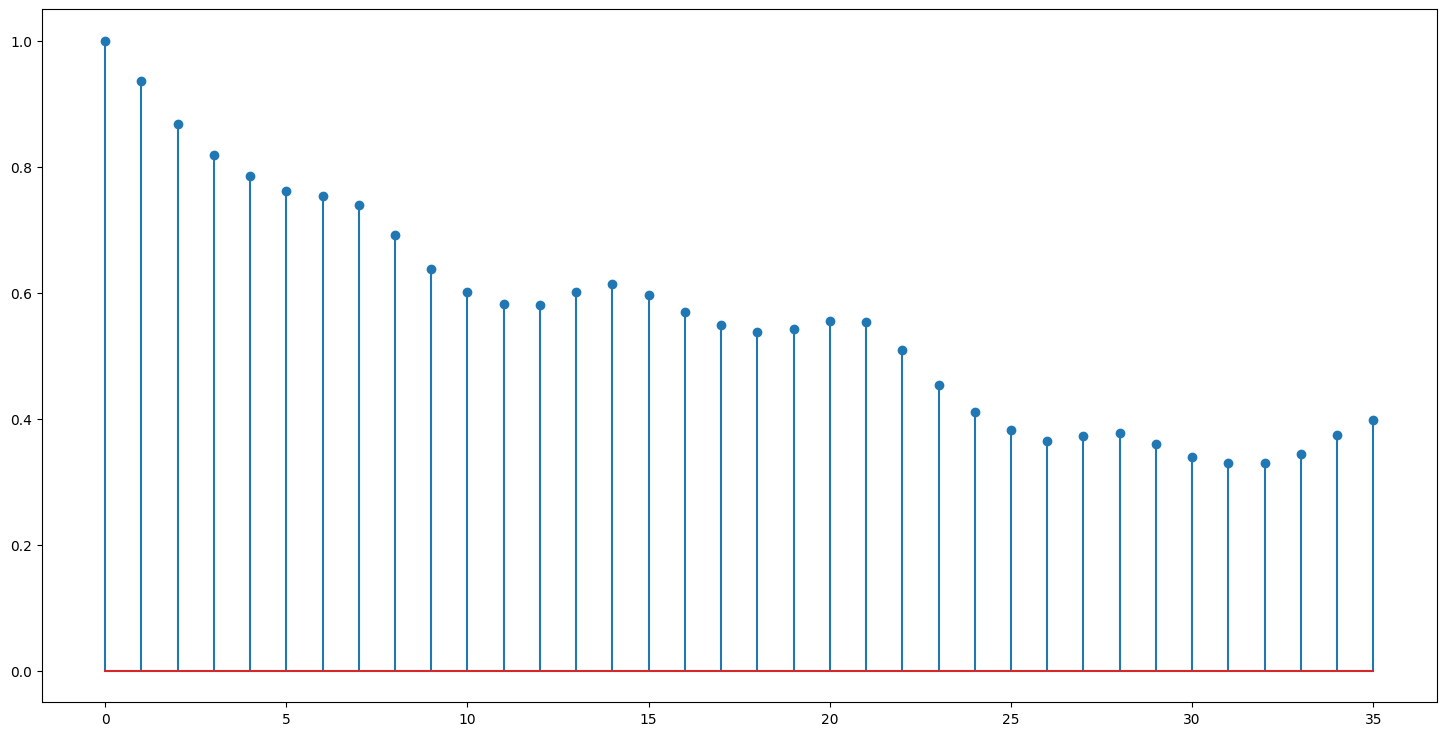

In [33]:
corr=[]
for lag in range(36):
    corr.append(np.corrcoef(df_lang.en[lag:], df_lang.en.shift(lag).dropna())[0][1])
plt.stem(np.arange(36),corr)

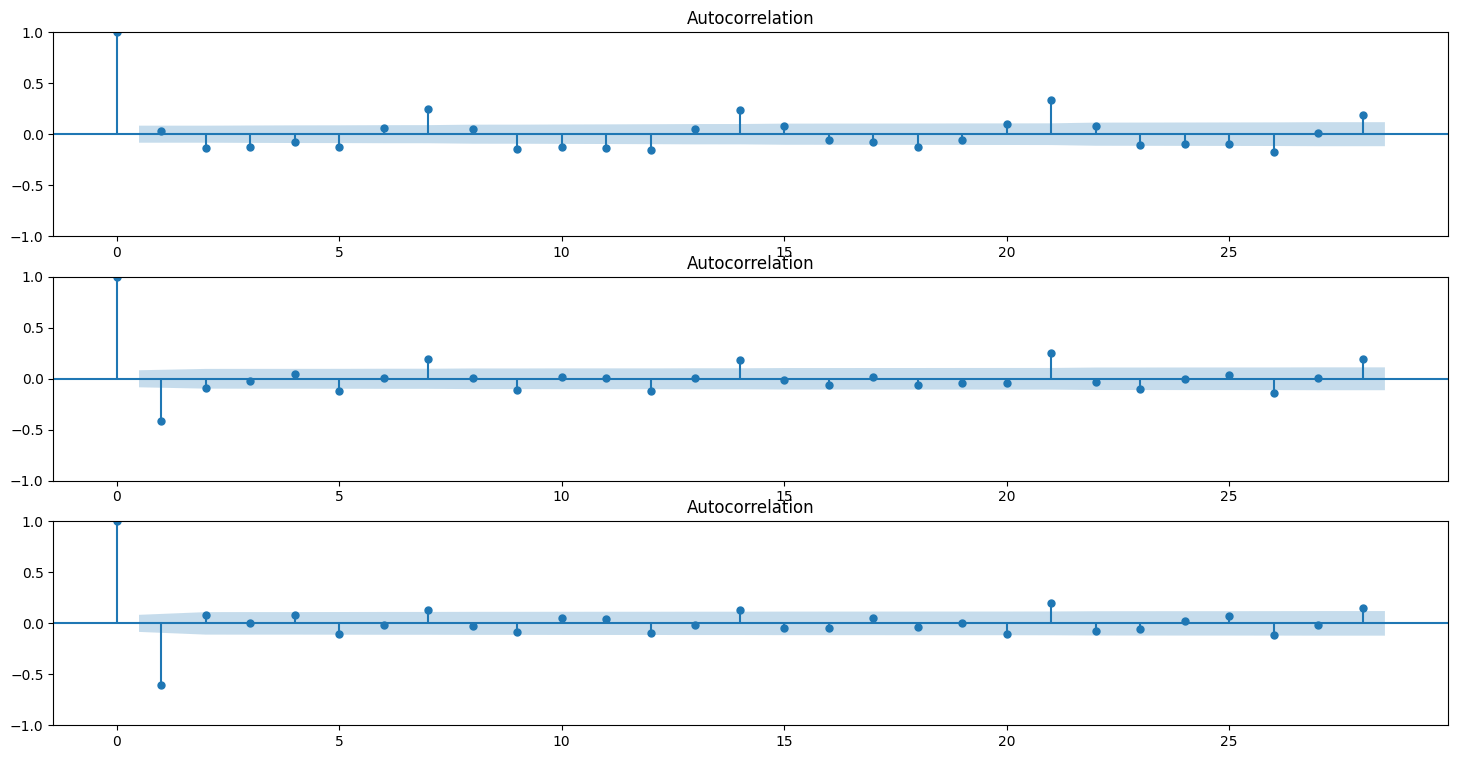

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax4, ax5, ax6) = plt.subplots(3)
plot_acf(ts_diff, ax=ax4)
plot_acf(ts_diff.diff().dropna(), ax=ax5)
plot_acf(ts_diff.diff().diff().dropna(), ax=ax6)
plt.show()

Here we can see that in second-order differencing the immediate bigger lag has gone on the negative side as compared to first-order, representing that in the second-order the series has become over the difference.

**Finding the value of the p parameter**

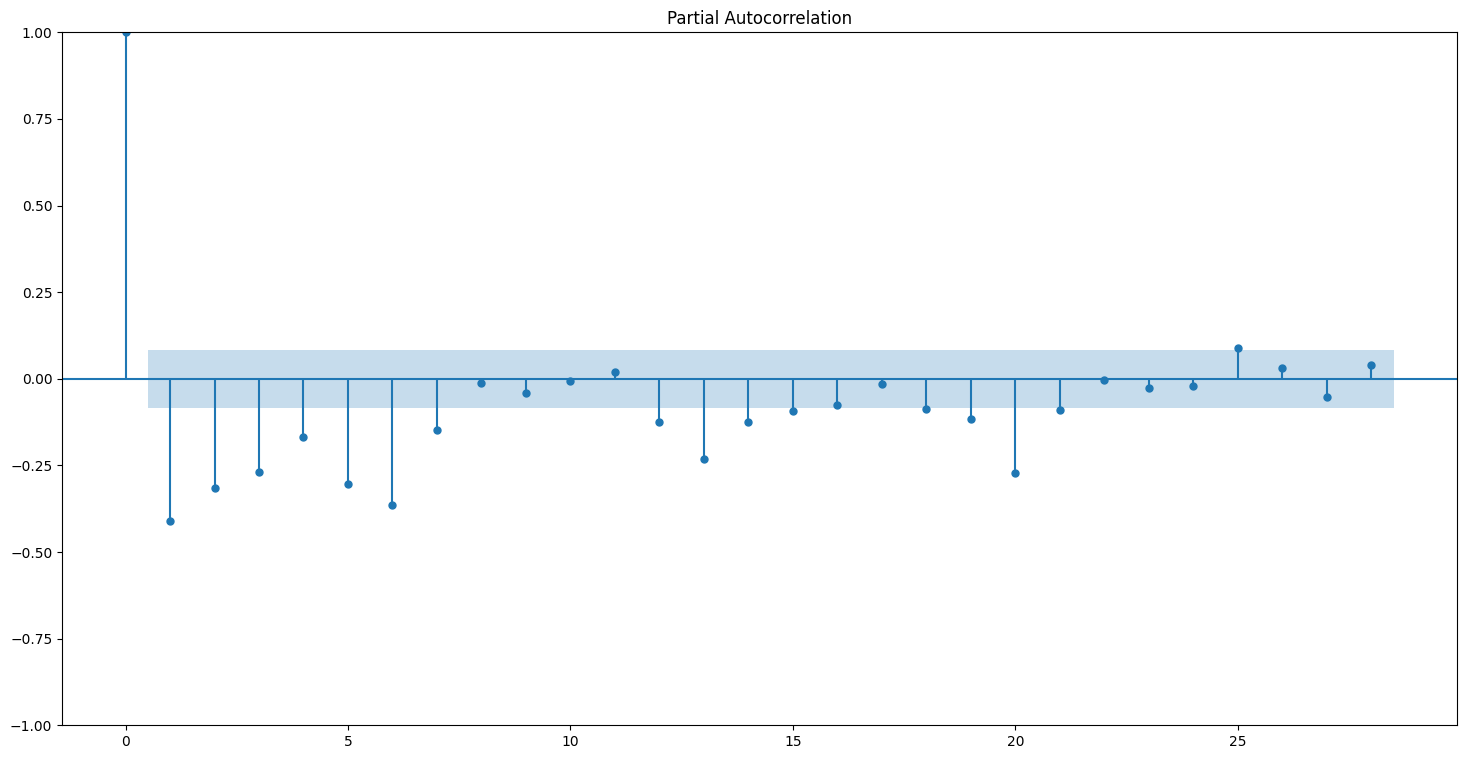

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts_diff.diff().dropna())
plt.show()

Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1.

**Finding the value of the q parameter**

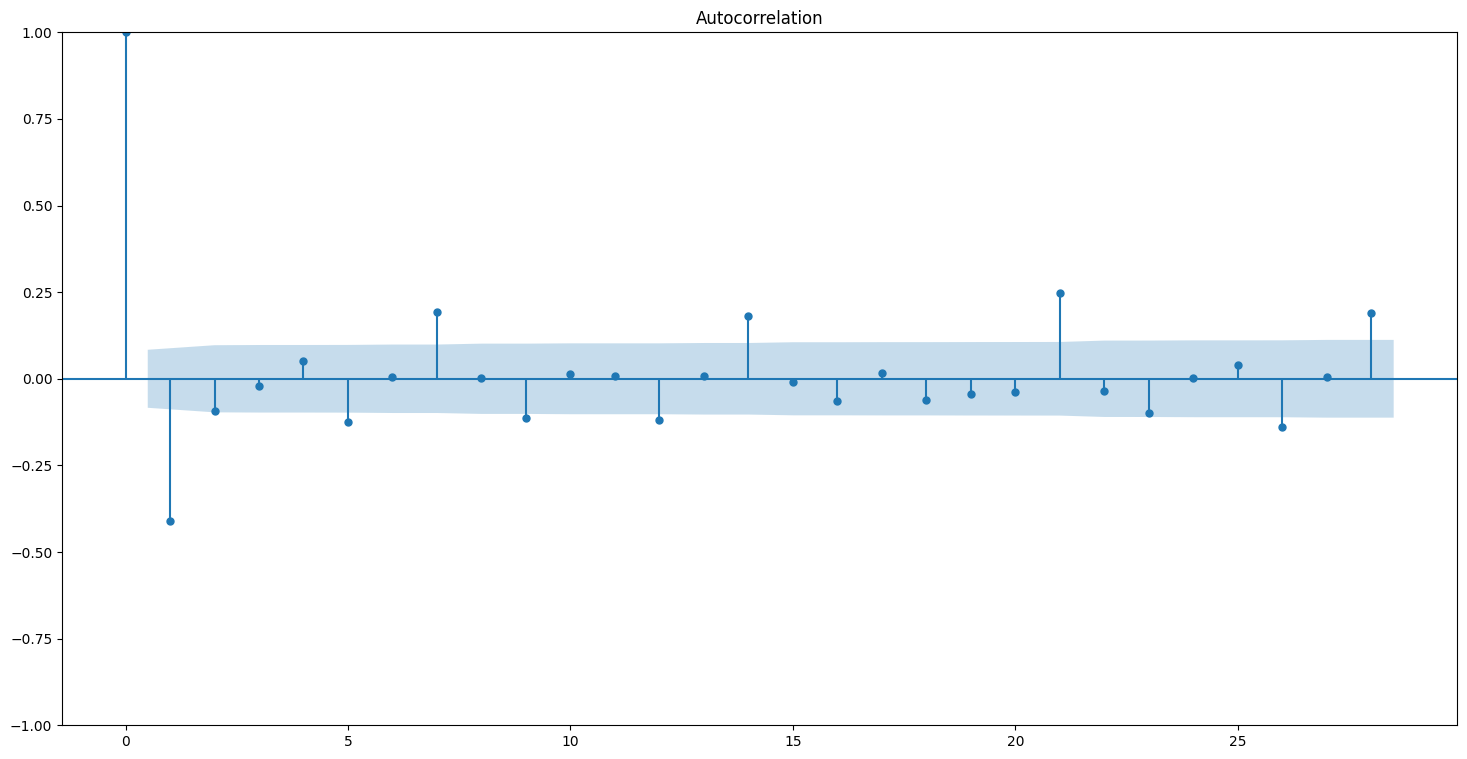

In [36]:
plot_acf(ts_diff.diff().dropna())
plt.show()

* In ARMA family models, for getting p (Auto-regressive order) we look at PACF plot, there is a cut-off at lag1 due to which it will be considered as the order of AR in ARMA.

* Similarly q(Moving Average order) will also be equal to 1 as the value of ACF at lag2 is significantly different from that at lag1. Therefore lag1 is also a cut-off point in ACF plot.

## **Model training and forecasting with ARIMA and SARIMAX**

In [37]:
# ARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(en_df, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     en   No. Observations:                  550
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3977.400
Date:                Thu, 17 Aug 2023   AIC                           7960.801
Time:                        20:29:29   BIC                           7973.725
Sample:                    07-01-2015   HQIC                          7965.852
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8871      0.023     39.368      0.000       0.843       0.931
ma.L1         -0.9786      0.010   -100.024      0.000      -0.998      -0.959
sigma2      1.147e+05   3217.934     35.654      0.0

In [38]:
model_fit.predict(dynamic=False)

2015-07-01       0.000000
2015-07-02    3493.463972
2015-07-03    3483.919776
2015-07-04    3317.991200
2015-07-05    3446.869669
                 ...     
2016-12-27    5700.525653
2016-12-28    5947.591502
2016-12-29    5785.639384
2016-12-30    6136.911565
2016-12-31    5191.351633
Freq: D, Name: predicted_mean, Length: 550, dtype: float64

### **Multistep Forecasting**

In [39]:
train = en_df[:-20]
test = en_df[-20:]

                               SARIMAX Results                                
Dep. Variable:                     en   No. Observations:                  530
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3825.514
Date:                Thu, 17 Aug 2023   AIC                           7661.028
Time:                        20:29:29   BIC                           7682.383
Sample:                    07-01-2015   HQIC                          7669.388
                         - 12-11-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6883      0.298      2.308      0.021       0.104       1.273
ar.L2         -0.0097      0.257     -0.038      0.970      -0.514       0.494
ma.L1         -0.6865      0.300     -2.289      0.0

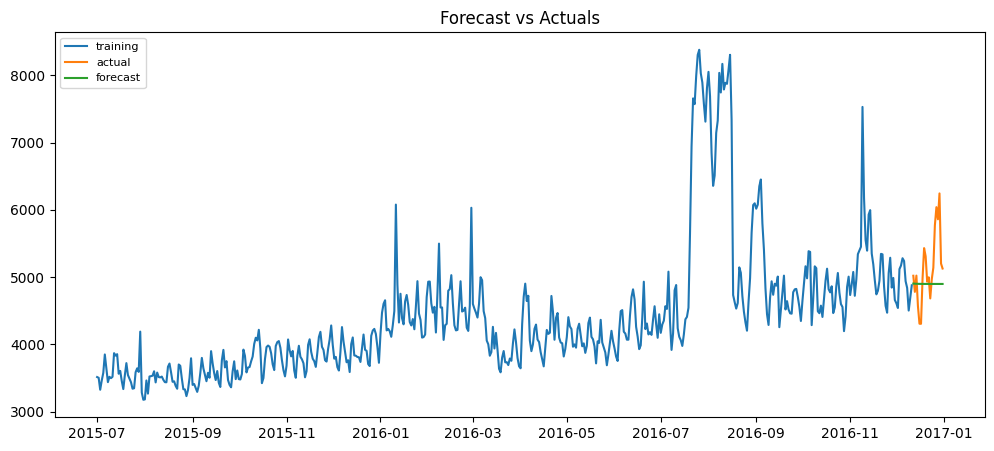

In [40]:
# SARIMAX model
model = SARIMAX(train, order=(2, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

# Forecast
fc = fitted.forecast(20, alpha=0.02)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

In [41]:
### How do you measure accuracy/performance

from sklearn.metrics import (mean_squared_error as mse,mean_absolute_error as mae,mean_absolute_percentage_error as mape)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 4))
    print('RMSE :', round(mse(actual, predicted)**0.5, 4)) 
    print('MAPE:', round(mape(actual, predicted), 4))


In [42]:
# actual --> test.values
# predicted --> fc.values
performance(test.values,fc.values)

MAE : 420.9317
RMSE : 564.9843
MAPE: 0.0785


We can see that the model does not perform very well for multistep out sample data, from the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [43]:
ex_df = pd.read_csv('Exog_Campaign_eng.csv')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [44]:
ex_df.shape

(550, 1)

In [45]:
exog=ex_df['Exog'].to_numpy()

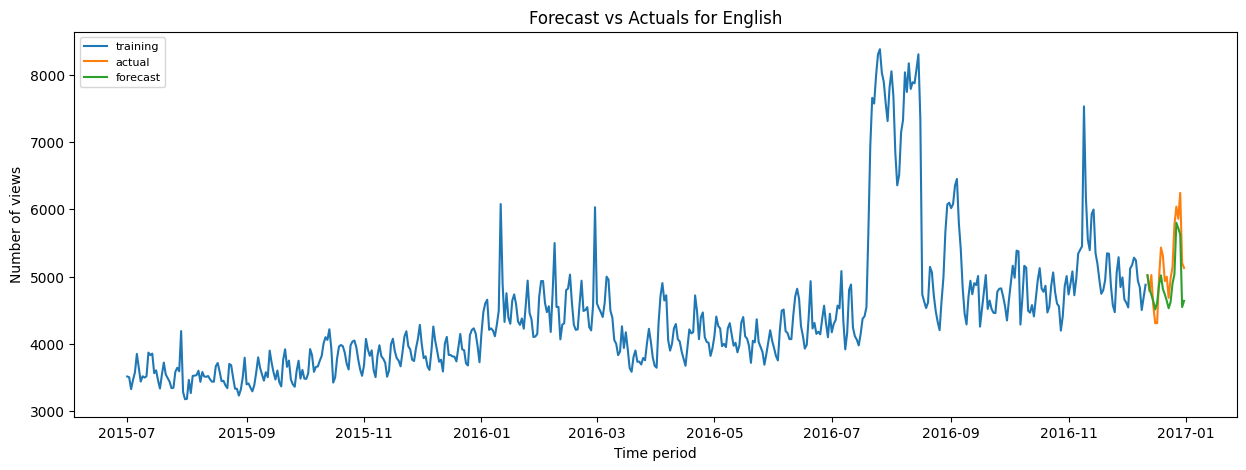

In [46]:
import statsmodels.api as sm
train=en_df[:530]
test=en_df[530:]
model=sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,7),exog=exog[:530])
results=model.fit()
fc=results.forecast(20,dynamic=True,exog=pd.DataFrame(exog[530:]))
fc_series = pd.Series(fc)
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals for English')
plt.xlabel('Time period')
plt.ylabel("Number of views")
plt.legend(loc='upper left', fontsize=8)

In [47]:
# actual --> test.values
# predicted --> fc.values
performance(test.values,fc.values)

MAE : 305.3414
RMSE : 367.0887
MAPE: 0.0582


The mean absolute percentage error and the root mean squared error is low.

## **Forecasting with Facebook Prophet**

In [48]:
ts_df = en_df.reset_index().copy()
ts_df.columns = [['ds', 'y']]
df2=ts_df.copy()
df2['exog'] = exog
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
0,2015-07-01,3513.862203,0
1,2015-07-02,3502.511407,0
2,2015-07-03,3325.357889,0
3,2015-07-04,3462.054256,0
4,2015-07-05,3575.520035,0


In [49]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      530 non-null    datetime64[ns]
 1   y       530 non-null    float64       
 2   exog    530 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.5 KB


In [50]:
# !pip install pystan~=2.14
# !pip install prophet

20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing


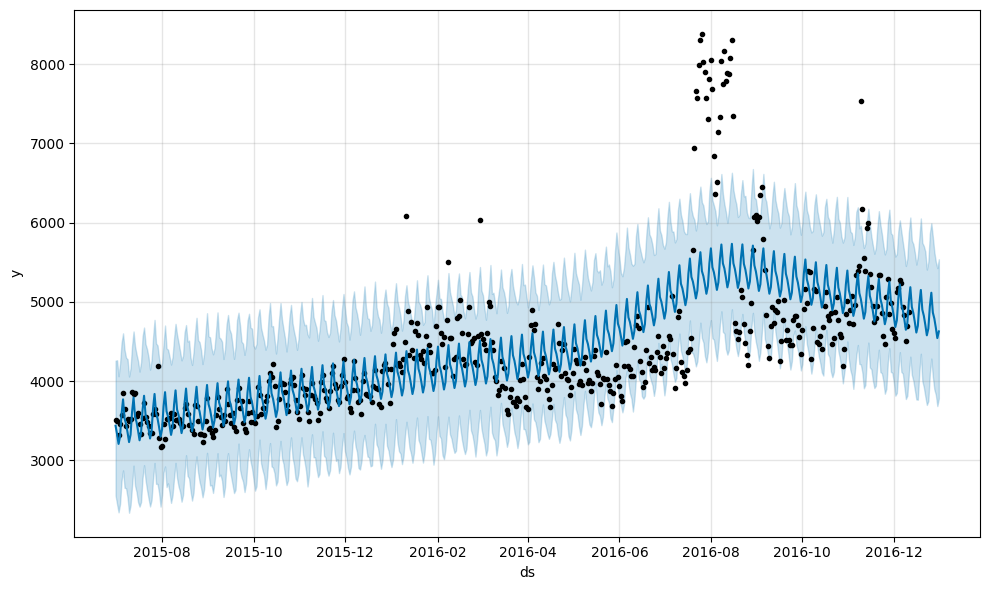

In [51]:
# prophet without exogenous
from prophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20]) 
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

20:29:32 - cmdstanpy - INFO - Chain [1] start processing
20:29:32 - cmdstanpy - INFO - Chain [1] done processing


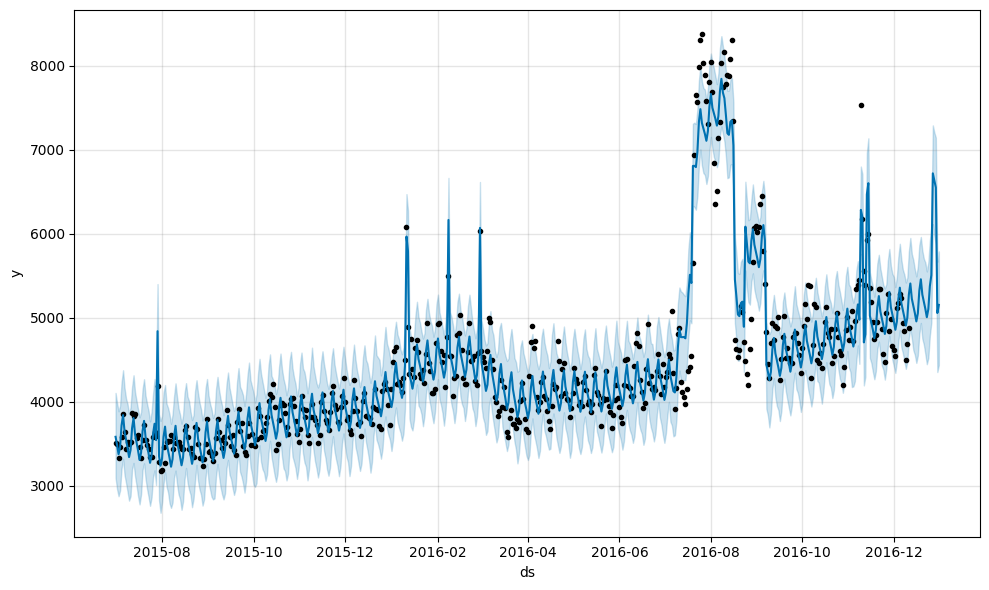

In [52]:
# prophet with exogenous
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog') 
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

In [53]:
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,exog,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,3601.754839,3095.524031,4105.440442,3601.754839,3601.754839,-19.176561,-19.176561,-19.176561,0.0,...,0.0,0.0,0.0,-19.176561,-19.176561,-19.176561,0.0,0.0,0.0,3582.578278
1,2015-07-02,3596.872374,2958.660750,3985.486295,3596.872374,3596.872374,-109.749721,-109.749721,-109.749721,0.0,...,0.0,0.0,0.0,-109.749721,-109.749721,-109.749721,0.0,0.0,0.0,3487.122653
2,2015-07-03,3591.989910,2874.831524,3886.181500,3591.989910,3591.989910,-217.047046,-217.047046,-217.047046,0.0,...,0.0,0.0,0.0,-217.047046,-217.047046,-217.047046,0.0,0.0,0.0,3374.942864
3,2015-07-04,3587.107445,2942.771613,3951.296396,3587.107445,3587.107445,-127.650262,-127.650262,-127.650262,0.0,...,0.0,0.0,0.0,-127.650262,-127.650262,-127.650262,0.0,0.0,0.0,3459.457183
4,2015-07-05,3582.224981,3205.223705,4229.804142,3582.224981,3582.224981,136.886110,136.886110,136.886110,0.0,...,0.0,0.0,0.0,136.886110,136.886110,136.886110,0.0,0.0,0.0,3719.111091


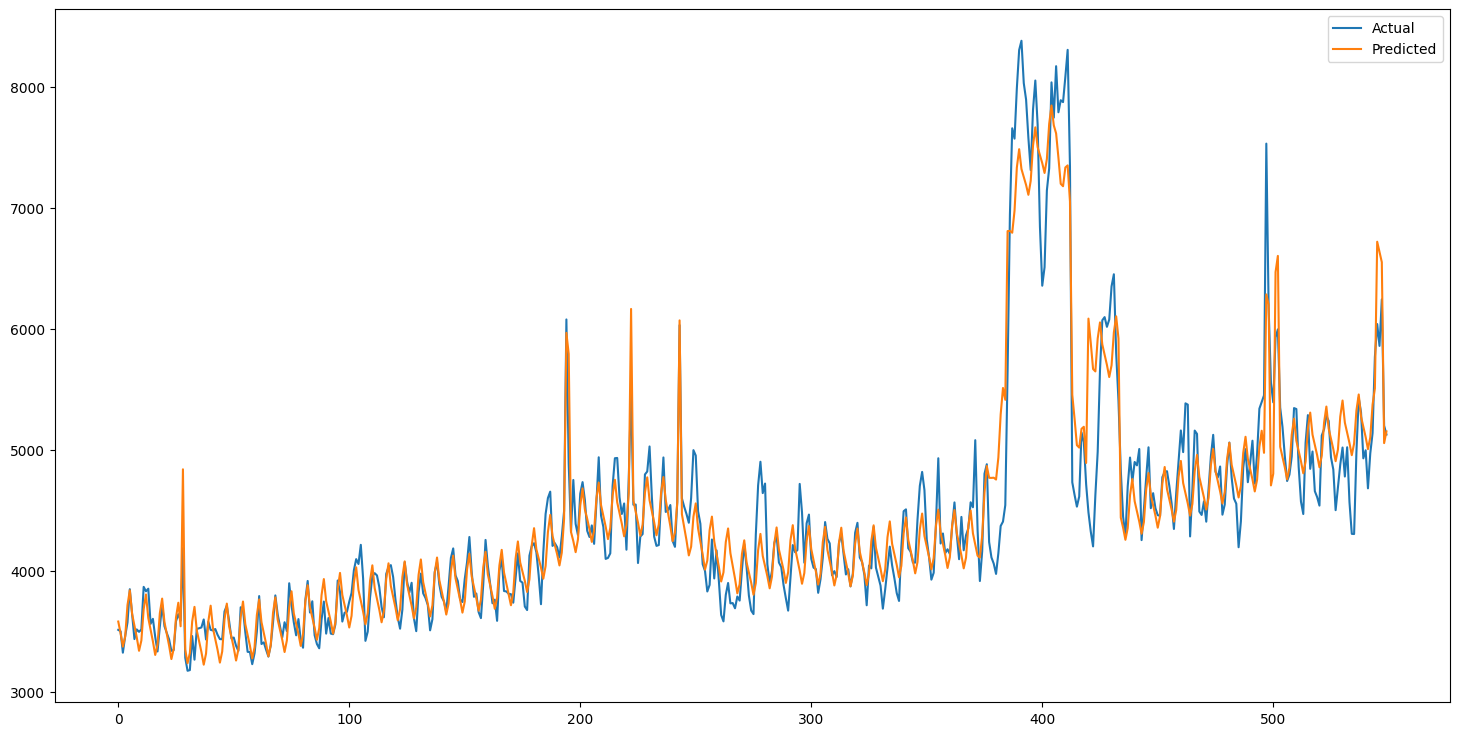

In [54]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [55]:
# actual --> df2['y'][-20:].values
# predicted --> forecast2['yhat'][-20:]
performance(df2['y'][-20:].values,forecast2['yhat'][-20:].values)

MAE : 325.0242
RMSE : 400.6227
MAPE: 0.0647


## **Creating a pipeline for working with multiple series**
Comparing the predicted views for different languages

### 1)**Function for Grid Search** 
- To get the best value of p,d,q
- The function returns mape and values for p,d,q.

In [56]:
# This functions works like a grid search for getting the best value of p,d,q by comparing the mape of all models that we create.
# the values of p,d,q that give the least mape score are saved and returned.

def grid_search(ts):
  v=[0,1,2,3]
  mape=100
  val=[0,0,0]
  for p in v:
    for d in v:
      for q in v:
        try:
          model = SARIMAX(ts[:-20], order=(p,d,q))
          model_fit = model.fit(disp=-1)
          fc = model_fit.forecast(20, alpha=0.02)
          x = np.mean(np.abs(fc.values - ts[-20:].values)/np.abs(ts[-20:].values))
          if(x<mape):
            mape=x
            val=[p,d,q]

        except:
          pass
  return (mape,val)

### 2) **Function for Modelling and Forecasting**

In [57]:
# This function takes the p,d,q values that we calculated earlier and then trains a model on it, does forecast and plots them for visualization.

# it also calculates the sum of forecased views for the next 30 days and returns it back

def all_arima(train,test,val):
  model = SARIMAX(train, order=(val[0], val[1], val[2]))
  fitted = model.fit(disp=-1)

  # Forecast
  fc = fitted.forecast(20, alpha=0.02)
  fc_series = pd.Series(fc.values, index=test.index)
  plt.figure(figsize=(12,5), dpi=100)
  plt.plot(train, label='training')
  plt.plot(test, label='actual')
  plt.plot(fc_series, label='forecast')
  plt.title('Forecast vs Actuals')
  plt.xlabel('Time period')
  plt.ylabel("Number of views")
  plt.legend(loc='upper left', fontsize=8)
  plt.show()
  mape = np.mean(np.abs(fc.values - test.values)/np.abs(test.values))
  rmse = np.mean((fc.values - test.values)**2)**.5
  print("mape:",mape.round(3))
  print("rsme:",rmse.round(3))
  
  return (fc)

In [58]:
df_language.head()

Language,de,en,es,fr,ja,no_lang,ru,zh
index,,,,,,,,
2015-07-01,714.968405,3513.862203,1085.972919,475.150994,580.647056,83.479922,629.999601,240.582042
2015-07-02,705.229741,3502.511407,1037.814557,478.202000,666.672801,87.471857,640.902876,240.941958
2015-07-03,676.877231,3325.357889,954.412680,459.837659,602.289805,82.680538,594.026295,239.344071
2015-07-04,621.145145,3462.054256,896.050750,491.508932,756.509177,70.572557,558.728132,241.653491
2015-07-05,722.076185,3575.520035,974.508210,482.557746,725.720914,78.214562,595.029157,257.779674


### **Function for Time series Forecasting model**

Language:  de
P value : 1.9250080772864015e-19
Alpha : 0.05
  >> Sequence is stationary


MAPE : 0.094106
[p,d,q] : [0, 3, 3]


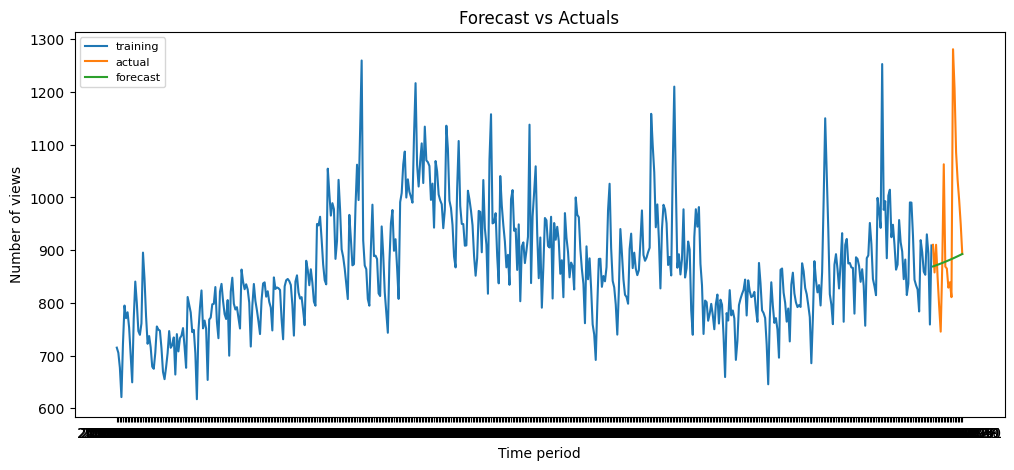

mape: 0.094
rsme: 142.565
----------------------------------------------------------------------------------------------------
Language:  en
P value : 1.4473735193702028e-11
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.071419
[p,d,q] : [1, 1, 1]


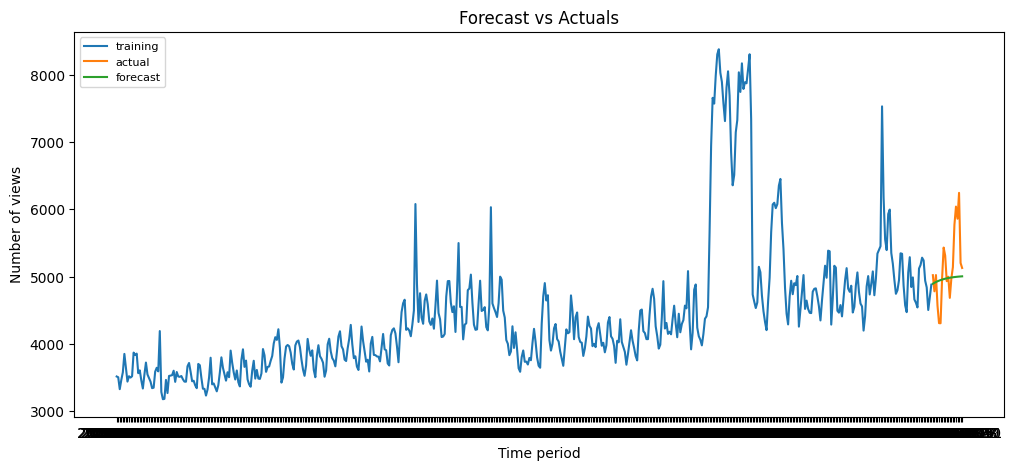

mape: 0.071
rsme: 523.651
----------------------------------------------------------------------------------------------------
Language:  es
P value : 8.528748714545128e-17
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.062859
[p,d,q] : [2, 1, 2]


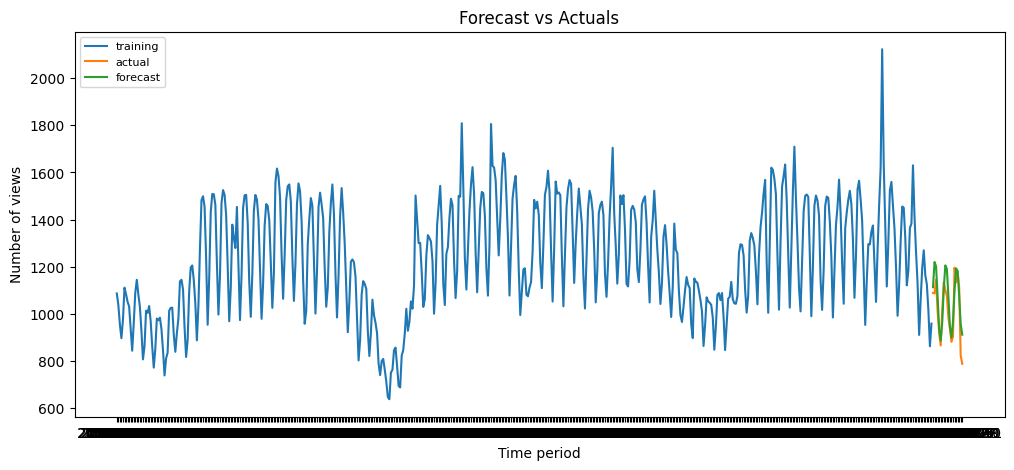

mape: 0.063
rsme: 75.463
----------------------------------------------------------------------------------------------------
Language:  fr
P value : 8.722236293920333e-16
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.087553
[p,d,q] : [2, 0, 3]


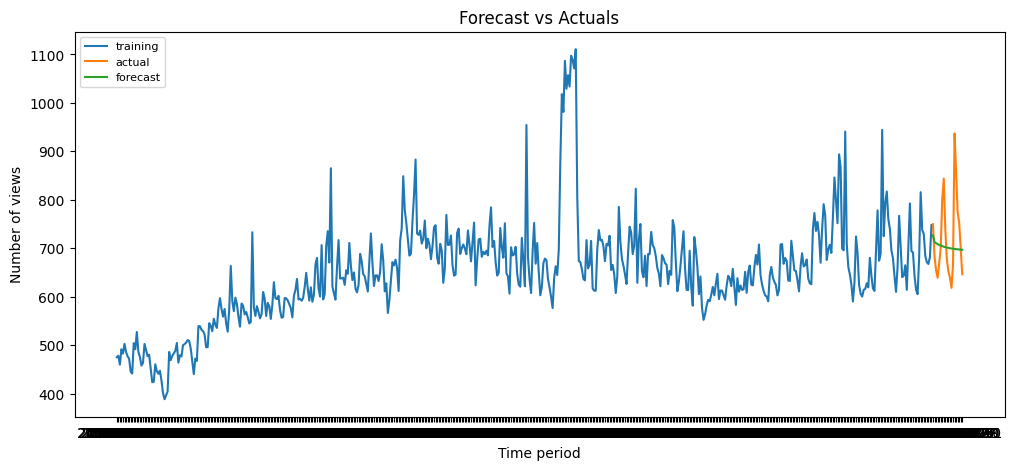

mape: 0.088
rsme: 86.424
----------------------------------------------------------------------------------------------------
Language:  ja
P value : 3.0781911055244466e-17
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.091081
[p,d,q] : [3, 1, 3]


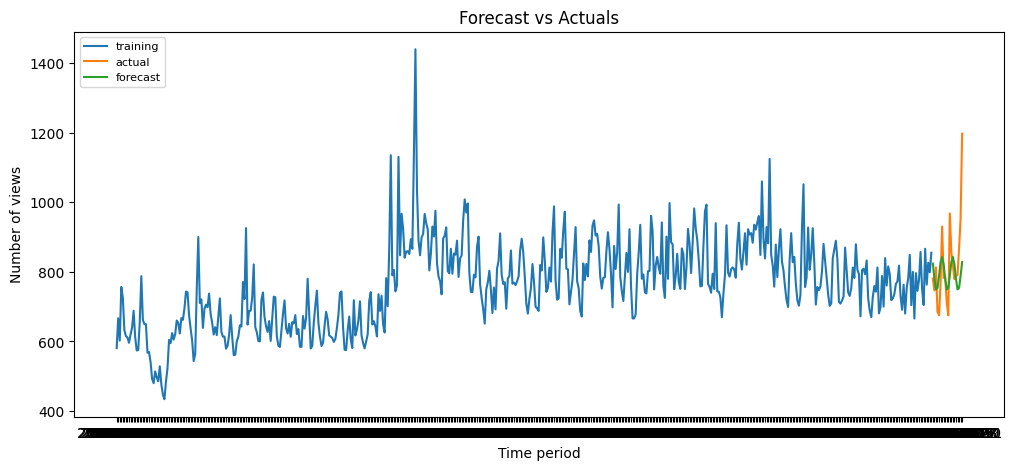

mape: 0.091
rsme: 113.561
----------------------------------------------------------------------------------------------------
Language:  no_lang
P value : 3.2578581376689034e-15
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.096824
[p,d,q] : [0, 1, 0]


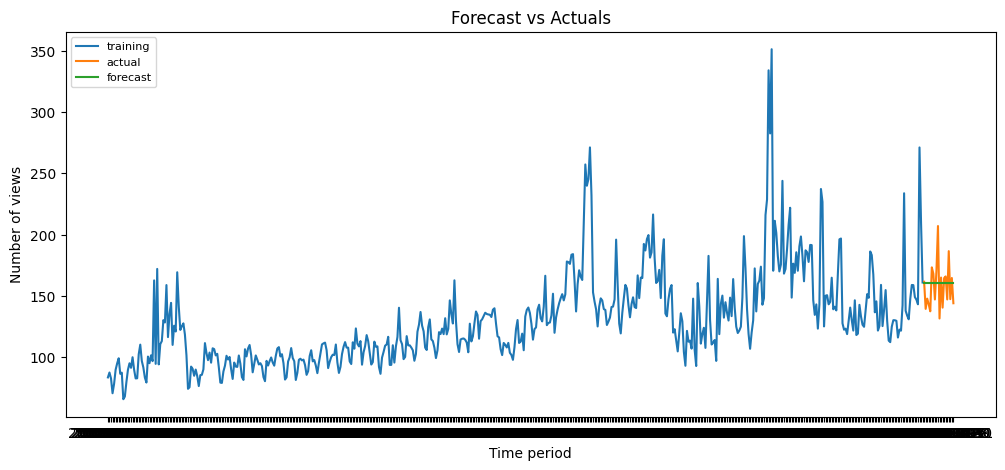

mape: 0.097
rsme: 18.399
----------------------------------------------------------------------------------------------------
Language:  ru
P value : 2.102228145842009e-12
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.055653
[p,d,q] : [2, 0, 3]


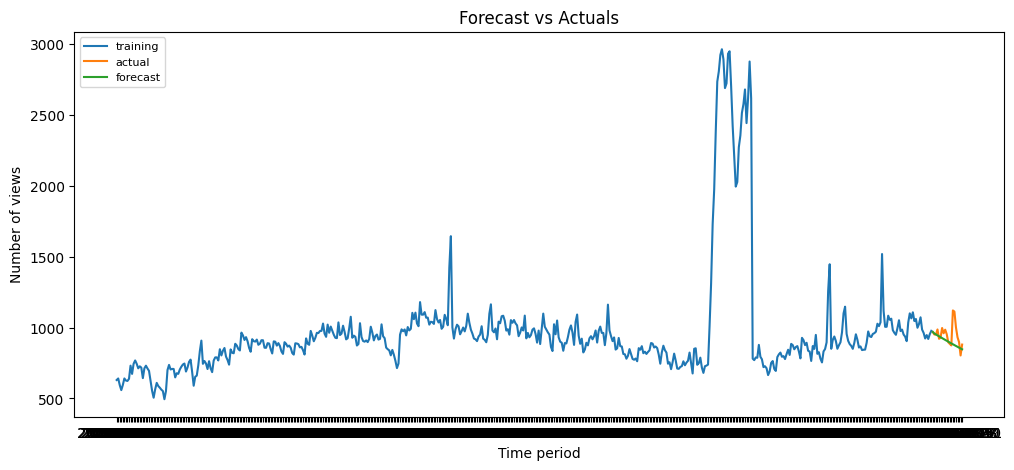

mape: 0.056
rsme: 88.333
----------------------------------------------------------------------------------------------------
Language:  zh
P value : 7.455607963193095e-13
Alpha : 0.05
  >> Sequence is stationary
MAPE : 0.057721
[p,d,q] : [3, 1, 2]


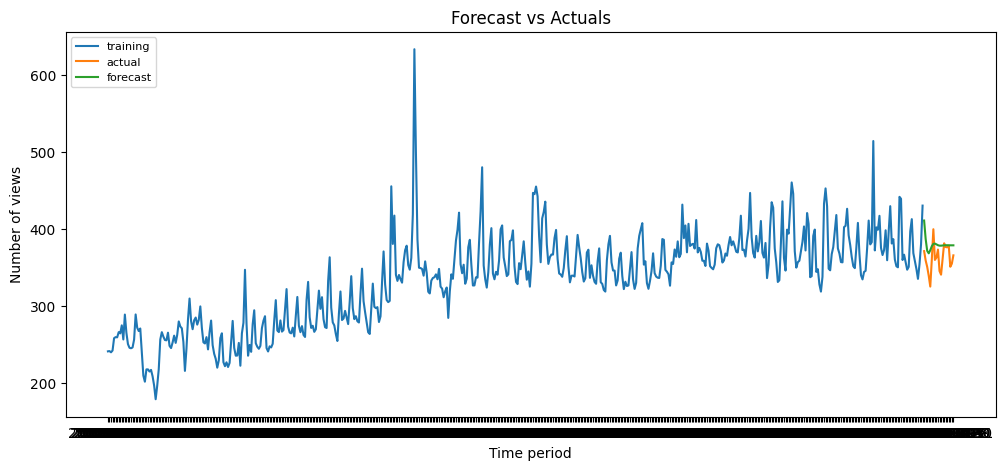

mape: 0.058
rsme: 24.203
----------------------------------------------------------------------------------------------------



In [59]:
# This function is what calls and drives all the other functions.

# It first gets the data for a particular language.

# checks stationarity.

# Gets the optimal p,d,q values from grid search

# uses that value to train the model, forecast and plot it


import warnings
warnings.filterwarnings("ignore")

views_prediction={}

for c in df_language:
  print("Language: ",c)
  decompose_result= sm.tsa.seasonal_decompose(df_language[c], period=12)  
  trend = decompose_result.trend
  seasonal = decompose_result.seasonal
  residual = decompose_result.resid
  # decompose_result.plot()
  p_value = sm.tsa.stattools.adfuller(decompose_result.resid.dropna())[1] 
  print('P value :',p_value)
  significance_level = 0.05
  print('Alpha :',significance_level)    
  if p_value <= significance_level:
      print('  >> Sequence is stationary')
  else:
    print('  >> Sequence is not stationary')
  ts=(df_language[c])
  mape,val=grid_search(ts)
  print('MAPE :',mape.round(6))
  print('[p,d,q] :',val)
  train = ts[:530]
  test = ts[530:]
  fc=all_arima(train,test,val)
  views_prediction[c]=fc  
  print('--'*50)
print()

# **Questionnaire:**

### **Defining the problem statements and where can this and modifications of this be used?** 
    ---> Done

### **Write 3 inferences you made from the data visualizations**
1. From comparision number of articles in each languag
{'ja':'Japanese', 'de':'German', 'en' : 'English', 'no_lang':'Media_File', 'fr':'French', 'zh':'Chinese', 'ru':'Russian', 'es':'Spanish'}
Most of the articles are from English language.
2. Access_type for maximum content is all_access, while  usage from desktop and mobile is almost the same
3. Organic view is far more than that of spiders or bots.
4. Some website have all nan values in the begining, that can be due to the fact that those were created after that time so there is no traffic reading for that time

### **What does the decomposition of series do?**
* The decomposition of a time series refers to the process of separating the series into its constituent components, typically a trend, seasonal, and residual components.

* The trend component represents the long-term behavior of the series, while the seasonal component captures the periodic fluctuations that occur within a year or other fixed time interval. The residual component represents the random variation in the series that cannot be explained by the trend or seasonal components.

* The decomposition of a time series can be useful for several reasons. 
> * It can help to identify patterns and trends in the data, which can be used to make predictions about future values. 
> * It can also be used to remove the seasonal component from the data, which can make it easier to analyze and compare the data across different time periods. 
> * Additionally, the decomposition of a time series can provide insight into the underlying factors that are driving the behavior of the series, which can be valuable for decision-making and problem-solving.

### **What level of differencing gave you a stationary series?**
 --> 1 st level differencing gave stationary series.

### **Difference between ARIMA, SARIMA, and SARIMAX.**
ARIMA, SARIMA, and SARIMAX are all time series models that are used for forecasting future values based on historical data.

* ARIMA stands for "AutoRegressive Integrated Moving Average" and is a model that uses a combination of autoregressive (AR) and moving average (MA) terms to capture the autocorrelation and seasonality of a time series. The "Integrated" part of the name refers to differencing the data to make it stationary. ARIMA is used for univariate time series analysis and forecasting.

* SARIMA stands for "Seasonal AutoRegressive Integrated Moving Average" and is an extension of ARIMA that includes seasonal terms in addition to the AR and MA terms. SARIMA is used for time series that exhibit seasonality.

* SARIMAX is an extension of SARIMA that includes exogenous variables, in addition to the seasonal terms and ARMA terms. The "X" in the name stands for "exogenous." Exogenous variables are external factors that are not part of the time series itself, but that may have an effect on the time series. SARIMAX is used for time series that are affected by external factors.

In summary, ARIMA is used for univariate time series, SARIMA is used for time series with seasonality, and SARIMAX is used for time series with both seasonality and exogenous variables.


### **Compare the number of views in different languages**
1. For Common aur null laguage together form highest number of views followed by Views in english laguage.
2. After English Articles in japnese laguage got more number of views followed by German language.
3. After German, French language have highest view compared to remaning laguages, while chinese and russian laguages has less number of views.

### **What other methods other than grid search would be suitable to get the model for all languages?**
One method for building a multiple series model is vector autoregression (VAR). VAR is a statistical model used to analyze the relationship between multiple time series variables.

* In a VAR model, each variable is expressed as a linear function of its past values and the past values of all the other variables in the system. The model assumes that each variable is influenced by its own past values and the past values of the other variables in the system.

* The VAR model can be extended to include exogenous variables, in which case the model is called vector autoregression with exogenous variables (VARX). Exogenous variables are external factors that are not part of the time series themselves, but that may have an effect on the time series.

* VAR and VARX models can be used to forecast future values of each variable in the system based on historical data. These models are commonly used in macroeconomic forecasting, finance, and other fields where multiple time series variables are of interest.

#### **By Mrudula A P**